# Extended Kalman Filter

## 問題

速度 $v$， ヨーレート $\gamma$ で動いている車両がある．また車両には，車両軸中心で $(d_x, d_y)$ の位置にGPSがついており，自車位置を観測することができる．

このとき，車両状態 $(x, y, \theta)$ を拡張カルマンフィルタにより推定する．

<div style="text-align:center">
<img src="./assets/fig2.png" width="300px">
</div>


## 考え方

推定する状態を $[x_t, v_t, \theta_t]$ とし，
システムに対する入力を $[v_t, \gamma_t]$ として状態方程式を立てる．

観測方程式は，GPSで得た車両中心の位置を絶対座標系に変換して，$z=[z^x, z^y]$ として立式する．


## 状態方程式

$$
\left[\begin{array}{c}
    x_{t/t-1} \\
    y_{t/t-1} \\
    \theta_{t/t-1} \\
\end{array}\right]
=
\left[\begin{array}{c}
    x_{t-1/t-1} + v_{t-1/t-1} \cos\theta \ \tau \\
    y_{t-1/t-1} + v_{t-1/t-1} \sin\theta \ \tau \\
    \theta_{t-1/t-1} + \gamma_{t-1} \tau \\
\end{array}\right]
$$

## 観測方程式

$$
\left[\begin{array}{c}
    z^x_{t/t-1} \\
    z^y_{t/t-1} \\
\end{array}\right]
=
\left[\begin{array}{c}
    x_{t/t-1} + dx \sin\theta + dy \cos\theta \\
    y_{t/t-1} - dx \cos\theta + dy \sin\theta \\
\end{array}\right]
$$

## ヤコビアン

$$
F
=
\left[\begin{array}{c}
    \frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial y} & \frac{\partial f_1}{\partial \theta} \\
    \frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial y} & \frac{\partial f_2}{\partial \theta} \\
    \frac{\partial f_3}{\partial x} & \frac{\partial f_3}{\partial y} & \frac{\partial f_3}{\partial \theta} \\
\end{array}\right]
=
\left[\begin{array}{c}
    1 & 0 & - v_{t/t-1} \sin\theta \ \tau \\
    0 & 1 & v_{t/t-1} \cos\theta \ \tau \\
    0 & 0 & 1
\end{array}\right]
$$

$$
G
=
\left[\begin{array}{c}
    \frac{\partial f_1}{\partial v} & \frac{\partial f_1}{\partial \gamma} \\
    \frac{\partial f_2}{\partial v} & \frac{\partial f_2}{\partial \gamma} \\
    \frac{\partial f_3}{\partial v} & \frac{\partial f_3}{\partial \gamma} \\
\end{array}\right]
=
\left[\begin{array}{c}
    \cos\theta \ \tau & 0 \\
    \sin\theta \ \tau & 0 \\
    0 & \tau \\
\end{array}\right]
$$

$$
H
=
\left[\begin{array}{c}
    \frac{\partial h_1}{\partial x} & \frac{\partial h_1}{\partial y} & \frac{\partial h_1}{\partial \theta} \\
    \frac{\partial h_2}{\partial x} & \frac{\partial h_2}{\partial y} & \frac{\partial h_2}{\partial \theta} \\
\end{array}\right]
=
\left[\begin{array}{c}
    1 & 0 & dx \cos\theta - dy \sin\theta \\
    0 & 1 & dx \sin\theta + dy \cos\theta \\
\end{array}\right]
$$

# 初期値・シミュレーション条件
演算周期 $\tau=0.010$ [s], 速度 $vel=5$ [m/s], ヨーレート $\gamma=0.1$ [rad/s]

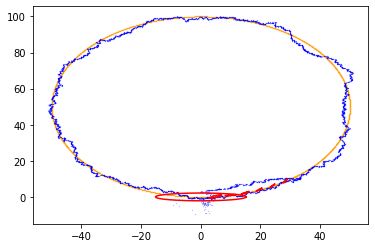

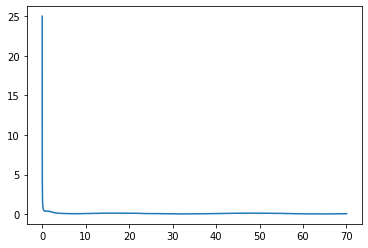

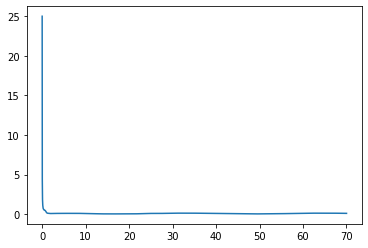

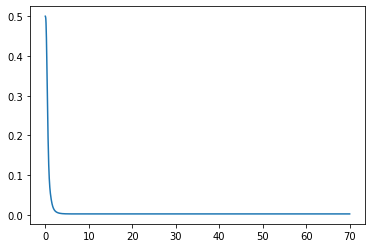

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
#* Settings *#
# =========================================================

# シミュレーションの設定
sim_t_limit = 70 # シミュレーション時間 [s]
tau = 0.010      # シミュレーション間隔 [s]
vel = 5          # 速度 [m/s]
yaw_rate = 0.1   # ヨーレート [rad/s]
dx = 0.1         # GPS 取り付け位置 (車両中心 x座標) [m]
dy = 0.1         # GPS 取り付け位置 (車両中心 y座標) [m]

# 状態方程式: 変数設定
x = np.array([0, 0, 0]).reshape(3, 1)

P = np.array([[25, 0, 0],
              [0, 25, 0],
              [0, 0, 0.5]])

Q = np.array([[1, 0],
              [0, 0.1]])

# 観測方程式: 変数設定
R = np.array([[16, 0],
              [0, 16]])


# =========================================================
#* Functions and Params for Error Ellipse *#
# =========================================================

# 誤差楕円を描くための関数・パラメータを定義する

chi_2 = 9.21034  # 次元が2で99%の信用区間のカイ二乗値

def rad2deg(a):
    return a * 180 / np.pi

def deg2rad(a):
    return a / 180 * np.pi

def err_ellipse(P, chi_2):
    """
    分散共分散行列から誤差楕円を算出する
    :param P            : 分散共分散行列, (x, y) の 2x2行列
    :param chi_2        : カイ二乗値
    :return ell_rotated : 誤差楕円 (原点中心)
    """
    # 固有値と固有ベクトルを取得
    # ※ 固有ベクトルは列ごとに格納される
    (w, v) = np.linalg.eig(P)
    
    # 固有値の大きい方と小さい方のインデックスを取得
    max_idx = np.argmax(w)
    min_idx = np.argmin(w)
    
    # 大きい方の固有値に対応する固有ベクトルの角度を求める
    #   np.arctan2(y, x)
    ang_r = np.arctan2(v[1, max_idx], v[0, max_idx])
    ang_d = ang_r * 180 / np.pi

    # 楕円のパラメータを取得する
    a = np.sqrt(w[max_idx] * chi_2)
    b = np.sqrt(w[min_idx] * chi_2)

    # 楕円を用意する
    t = list(np.arange(0, deg2rad(360+1), deg2rad(5)))
    ell = np.array([a * np.cos(t), b * np.sin(t)])

    # 誤差楕円の回転
    R = np.array([[np.cos(ang_r), np.sin(ang_r)],
                  [-np.sin(ang_r), np.cos(ang_r)]])

    ell_rotated = np.matmul(R, ell)
    
    return ell_rotated


# =========================================================
#* Define Functions *#
# =========================================================

# jacobian: F
def jacob_F(vel, theta, tau):
    F = np.array([[1, 0, - vel * np.sin(theta) * tau],
                  [0, 1, vel * np.cos(theta) * tau],
                  [0, 0, 1]])
    return F

# jacobian: G
def jacob_G(theta, tau):
    G = np.array([[np.cos(theta)*tau, 0],
                  [np.sin(theta)*tau, 0],
                  [0, tau]])
    return G

# jacobian: H
def jacob_H(dx, dy, theta):
    H = np.array([[1, 0, dx*np.cos(theta) - dy*np.sin(theta)],
                  [0, 1, dx*np.sin(theta) + dy*np.cos(theta)]])
    return H

# 状態更新式 (非線形)
def est_x(x, vel, raw_rate):
    pos_x_pre = x[0, 0]
    pos_y_pre = x[1, 0]
    theta_pre = x[2, 0]
    
    x[0, 0] = pos_x_pre + vel * np.cos(theta_pre) * tau
    x[1, 0] = pos_y_pre + vel * np.sin(theta_pre) * tau
    x[2, 0] = theta_pre + raw_rate * tau

    return x

# 観測更新式 (非線形)
def est_z(x, dx, dy):
    pos_x = x[0, 0]
    pos_y = x[1, 0]
    theta = x[2, 0]
    
    z_x = pos_x + dx * np.sin(theta) + dy * np.cos(theta)
    z_y = pos_y - dx * np.cos(theta) + dy * np.sin(theta)
    
    z = np.array([z_x, z_y]).reshape(2, 1)
    return z

# 真の状態更新 (Ground Truth)
def update_true_x(true_x, vel, yaw_rate, tau):
    true_pos_x_pre = true_x[0, 0]
    true_pos_y_pre = true_x[1, 0]
    true_theta_pre = true_x[2, 0]
  
    out = np.empty(3).reshape(true_x.size, 1)
    out[0, 0] = true_pos_x_pre + vel * np.cos(true_theta_pre) * tau
    out[1, 0] = true_pos_y_pre + vel * np.sin(true_theta_pre) * tau
    out[2, 0] = true_theta_pre + yaw_rate * tau
    
    return out


# =========================================================
#* Simulation *#
# =========================================================

# 初期化
true_x = x  # 真の状態
t = 0       # シミュレーション経過時間

# 結果表示用リスト
t_list = [0]
true_pos_x_list = [x[0, 0]]
true_pos_y_list = [x[1, 0]]
true_theta_list = [x[2, 0]]
pos_x_list = [x[0, 0]]
pos_y_list = [x[1, 0]]
theta_list = [x[2, 0]]
pos_x_var_list = [P[0, 0]]
pos_y_var_list = [P[1, 1]]
theta_var_list = [P[2, 2]]
err_ell_list = [err_ellipse(P, chi_2)]

while (t < sim_t_limit):
    #* 真の状態更新 (Ground Truth) *#
    true_x = update_true_x(true_x, vel, yaw_rate, tau)

    #* ヤコビアン算出 *#
    theta = x[2, 0]
    F = jacob_F(vel, theta, tau)
    G = jacob_G(theta, tau)
    H = jacob_H(dx, dy, theta)
    
    #* 予測ステップ *#
    x = est_x(x, vel, yaw_rate)
    P = np.matmul(np.matmul(F, P), F.T) + np.matmul(np.matmul(G, Q), G.T)
    

    #* 計測更新ステップ *#
    # センサによる観測
    sens_z = true_x[0:2, 0].reshape(2, 1) + np.diag(np.random.normal(loc=0, scale=R)).reshape(2, 1)
    
    # 観測予測誤差
    tilde_z = sens_z - est_z(x, dx, dy)
    
    # 観測予測誤差分散
    S = np.matmul(np.matmul(H, P), H.T) + R
    
    # カルマンゲイン
    K = np.matmul(np.matmul(P, H.T), np.linalg.inv(S))

    # 状態更新
    x = x + np.matmul(K, tilde_z)
    P = P - np.matmul(np.matmul(K, S), K.T)
    
    # シミュレーション時間更新
    t += tau
    
    # 結果格納
    t_list.append(t)
    true_pos_x_list.append(true_x[0, 0])
    true_pos_y_list.append(true_x[1, 0])
    true_theta_list.append(true_x[2, 0])
    pos_x_list.append(x[0, 0])
    pos_y_list.append(x[1, 0])
    theta_list.append(x[2, 0])
    pos_x_var_list.append(P[0, 0])
    pos_y_var_list.append(P[1, 1])
    theta_var_list.append(P[2, 2])
    
    # 誤差楕円格納
    err_ell = err_ellipse(P, chi_2)
    err_ell_list.append(err_ell)


#* プロット *#

# 真の位置 (オレンジ) と推定位置 (ブルー)
plt.figure()
plt.scatter(true_pos_x_list, true_pos_y_list, s=0.01, c='orange')
plt.scatter(pos_x_list, pos_y_list, s=0.01, c='blue')

# 誤差楕円の描画 (最初の1/10まで)
for i in range(0, int(len(err_ell_list) / 10), 100):
    err_ell = err_ell_list[i]
    plt.plot(err_ell[0, :] + true_pos_x_list[i], err_ell[1, :] + true_pos_y_list[i], color='r')
    
# 分散値 (x)
plt.figure()
plt.plot(t_list, pos_x_var_list)

# 分散値 (y)
plt.figure()
plt.plot(t_list, pos_y_var_list)

# 分散値 (theta)
plt.figure()
plt.plot(t_list, theta_var_list)



位置 $(x, y)$, ヨー角 $\theta$ の分散は小さくなっているのが分かります．

真値 (オレンジ) に対して，推定位置 (青) もそこそこ良さそうです．

誤差楕円 (赤の楕円) は最初の 1/10 の範囲で等間隔的に描いていますが，初期の楕円がすぐに小さくなっているのが確認できます．(2回目以降小さすぎて見にくいですが...)

※ ちなみにカイ二乗値は 99% で設定しているので，誤差楕円の意味合いとしては「99%の確率で楕円の中にいるということを意味します」